In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Tuple

/opt/anaconda3/envs/pytorch_unet/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/pytorch_unet/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/anaconda3/envs/pytorch_unet/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <85021449-F141-385B-8151-410662B4D328> /opt/anaconda3/envs/pytorch_unet/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
history_size = 96
predict_size = 96
input_size = 1
hidden_size = 128
n_layers = 4
n_epoch = 3
lr = 0.001

train_split = 4000

In [3]:
class LSTMCell(nn.Module):
    def __init__(self, input_size : int, hidden_size : int):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_lin = nn.Linear(hidden_size, 4 * hidden_size)
        self.input_lin = nn.Linear(input_size, 4 * hidden_size, bias=False)

    def forward(self, x, h_in, c_in):
        X = self.input_lin(x) + self.hidden_lin(h_in) # 입력과 은닉 상태를 선형 변환 후 더함
        i, f, g, o = X.chunk(4, dim=-1)

        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)

        c_next = c_in * f + i * g
        h_next = torch.tanh(c_next) * o

        return h_next, c_next

In [4]:
class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, n_layers: int):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.cells = nn.ModuleList(
            [LSTMCell(input_size=input_size, hidden_size=hidden_size)] +
            [LSTMCell(input_size=hidden_size, hidden_size=hidden_size) for _ in range(n_layers - 1)]
        )
        self.linear = nn.Linear(self.hidden_size, 1)

    def forward(self, x: torch.Tensor, state: Optional[Tuple[torch.Tensor, torch.Tensor]] = None):
        batch_size, seq_len, _ = x.shape

        if state is None:
            h = [x.new_zeros(batch_size, self.hidden_size) for _ in range(self.n_layers)]
            c = [x.new_zeros(batch_size, self.hidden_size) for _ in range(self.n_layers)]
        else:
            h, c = state
            h, c = list(torch.unbind(h)), list(torch.unbind(c))

        outputs = []  # 각 time step의 출력을 담는 리스트
        for t in range(seq_len):
            inp = x[:, t, :]  # 각 시점의 입력
            for layer in range(self.n_layers):
                h[layer], c[layer] = self.cells[layer](inp, h[layer], c[layer])
                inp = h[layer]
            outputs.append(self.linear(h[-1]))  # 각 time step에서 마지막 layer의 hidden state를 사용해 예측

        outputs = torch.stack(outputs, dim=0)  # 모든 time step의 예측을 쌓음
        h = torch.stack(h)
        c = torch.stack(c)
        return outputs[:, -predict_size:, -1], (h, c)


In [5]:
data_csv = pd.read_csv("../dataset/gc19_a.csv")
uni_data = data_csv['avgcpu']
uni_data.index = data_csv['time'] # index로 매핑

uni_data.head()

time
1556669400000000    0.382435
1556669700000000    0.378298
1556670000000000    0.483908
1556670300000000    0.552523
1556670600000000    0.576535
Name: avgcpu, dtype: float64

In [6]:
def univariate_data(dataset, start_index, end_index, history_size, target_size, step, single_step=False):
    datas = []
    labels = []

    start_index = start_index + history_size

    if end_index == None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        datas.append(np.reshape(dataset[indices], (history_size,1)))

        if single_step: # 단기 예측
            labels.append(dataset[i + target_size])
        else: # 장기 예측
            labels.append(dataset[i:i + target_size])

    return np.array(datas), np.array(labels)

def multivariate_data(dataset, start_index, end_index, history_size, target_size, step, single_step=False):
    datas = []
    labels = []

    start_index = start_index + history_size

    if end_index == None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        datas.append(dataset[indices])

        if single_step: # 단기 예측
            labels.append(dataset[i + target_size])
        else: # 장기 예측
            labels.append(dataset[i:i + target_size])

    return np.array(datas), np.array(labels)

In [7]:
# 정규화
uni_data = uni_data.values
uni_train_mean = uni_data[:train_split].mean()
uni_train_std = uni_data[:train_split].std()

uni_data = (uni_data - uni_train_mean) / uni_train_std

In [8]:
x_train_uni, y_train_uni = univariate_data(uni_data, 0, train_split, history_size, predict_size, 1, False)
x_test_uni, y_test_uni = univariate_data(uni_data, train_split, None, history_size, predict_size, 1, False)


In [9]:
def create_time_steps(length):
    if length >= 0:
        return range(0, length)
    else:
        return range(length, 0)

def show_plot(plot_data, delta, title):
    labels = ["history", "true future", "baseline"]
    marker = ["-", "r-", "g-"]
    time_steps = create_time_steps(-plot_data[0].shape[0])
    if delta: future = delta
    else: future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(create_time_steps(x.shape[0]), plot_data[i], marker[i], label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

    plt.legend()
    plt.axis('auto')
    plt.xlabel('time-steps')
    return plt


(96, 1) range(-96, 0)
(96,) range(0, 96)


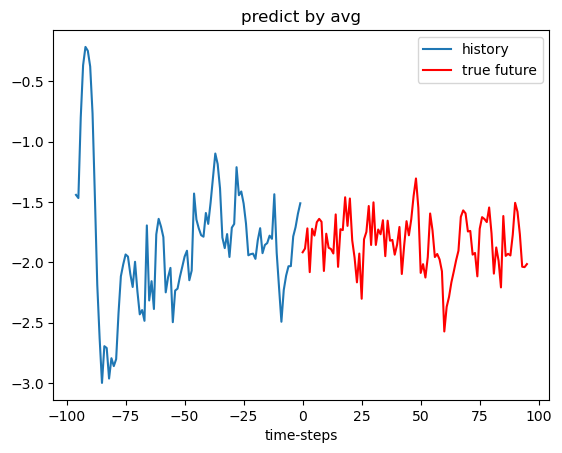

In [10]:
show_plot([x_train_uni[0], y_train_uni[0]], predict_size, "predict by avg").show()

In [11]:
model = LSTM(input_size=input_size, hidden_size=hidden_size, n_layers=n_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)

In [12]:
# x_train_uni = DataLoader(dataset=torch.tensor(x_train_uni, dtype=torch.float), batch_size=100, num_workers=2, shuffle=False)
# y_train_uni = DataLoader(dataset=torch.tensor(y_train_uni, dtype=torch.float), batch_size=100, num_workers=2, shuffle=False)

x_train_uni = torch.tensor(x_train_uni, dtype=torch.float)
y_train_uni = torch.tensor(y_train_uni, dtype=torch.float)

In [13]:
def train(X, Y, model, criterion, optimizer, epoch):
    model.train()

    for ep in range(epoch):
        h, c = None, None  # 초기화
        for batch, data in enumerate(X):
            optimizer.zero_grad()
            data = data.unsqueeze(0)
            # 이전 배치에서 hidden state와 cell state가 있으면 detach()
            if h is not None and c is not None:
                h = h.detach()
                c = c.detach()
                pred, (h, c) = model(data, (h,c))  # 상태를 전달
            else:
            # 모델의 출력과 새로운 hidden state, cell state
                pred, (h, c) = model(data, None)  # 상태를 전달

            # 손실 계산 및 역전파
            loss = criterion(Y[batch], pred.squeeze(1))
            loss.backward()

            optimizer.step()

            # 100번째 배치마다 손실 출력
            if batch % 100 == 0:
                print(f"Epoch: {ep}; Batch: {batch}; Loss: {loss.item()};")
                show_plot([data[0, :], Y[batch], pred.detach().numpy()], predict_size, "predict by lstm").show()


Epoch: 0; Batch: 0; Loss: 3.583984613418579;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


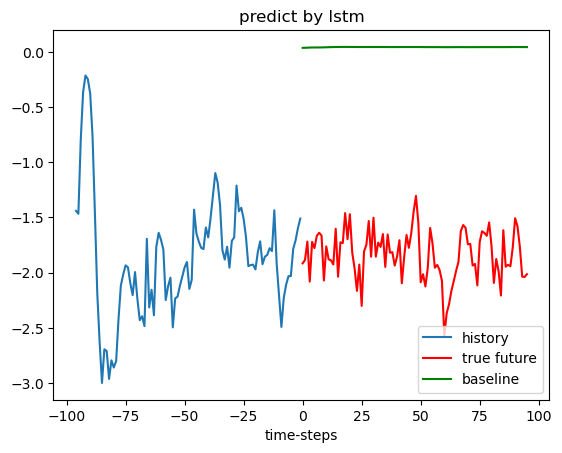

Epoch: 0; Batch: 100; Loss: 0.9941298365592957;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


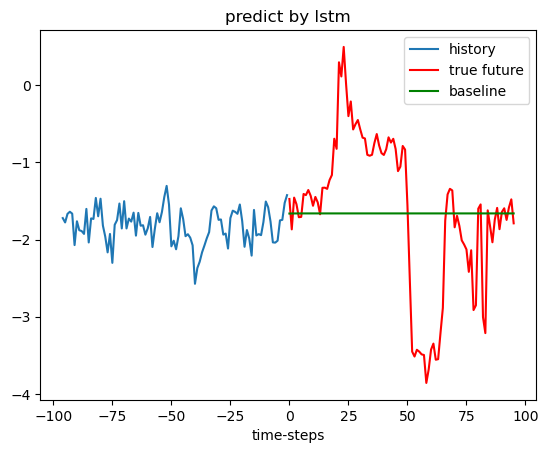

Epoch: 0; Batch: 200; Loss: 0.2651185989379883;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


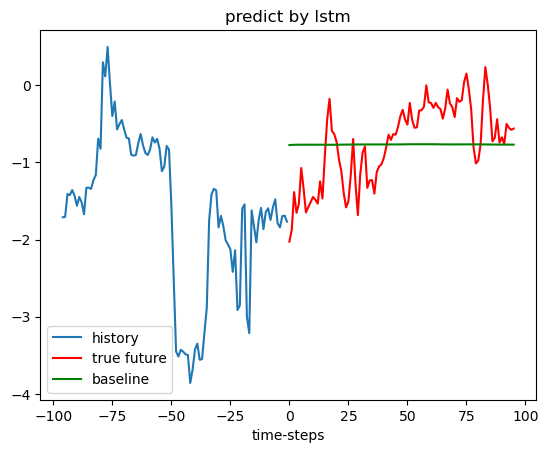

Epoch: 0; Batch: 300; Loss: 0.040209099650382996;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


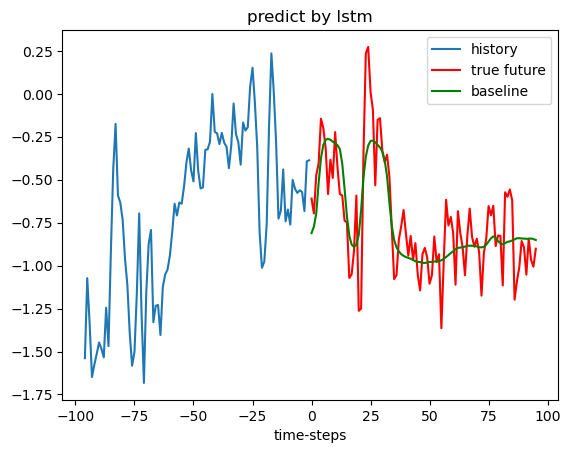

Epoch: 0; Batch: 400; Loss: 0.43059587478637695;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


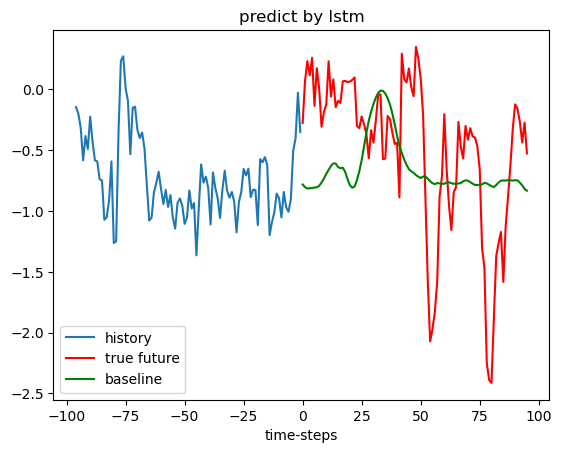

Epoch: 0; Batch: 500; Loss: 0.11831115931272507;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


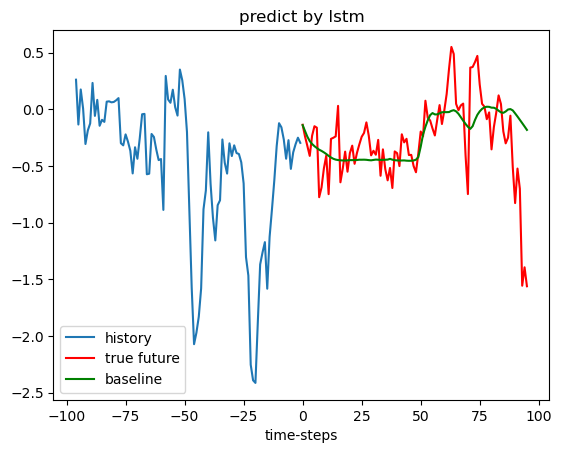

Epoch: 0; Batch: 600; Loss: 0.29756489396095276;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


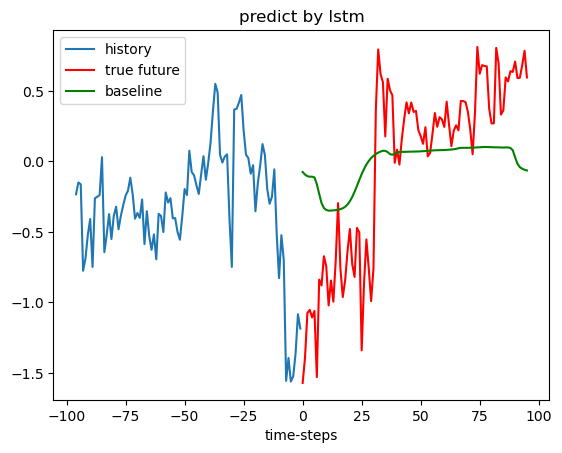

Epoch: 0; Batch: 700; Loss: 0.07568267732858658;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


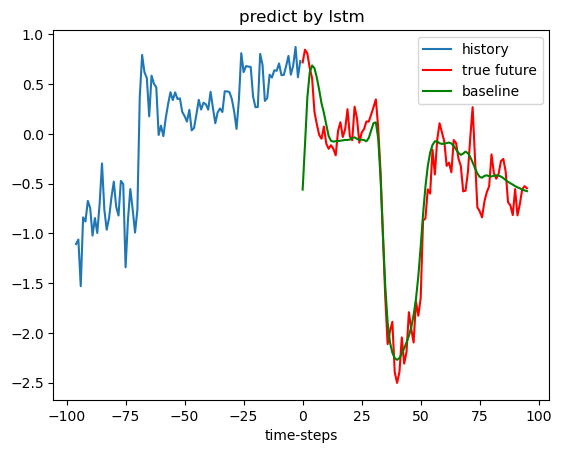

Epoch: 0; Batch: 800; Loss: 0.26864826679229736;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


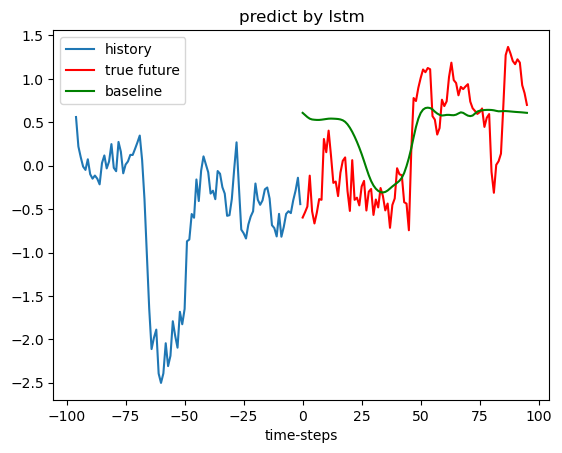

Epoch: 0; Batch: 900; Loss: 0.8228103518486023;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


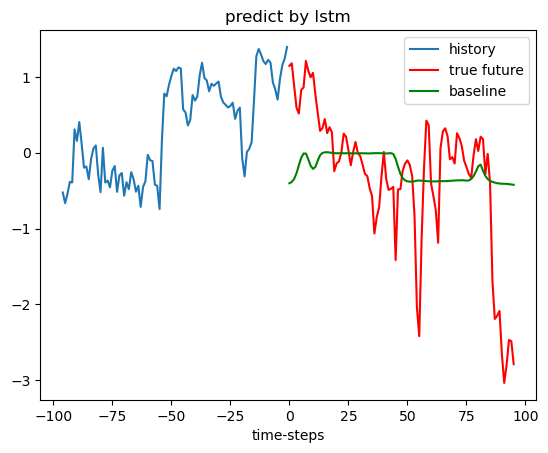

Epoch: 0; Batch: 1000; Loss: 0.24895189702510834;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


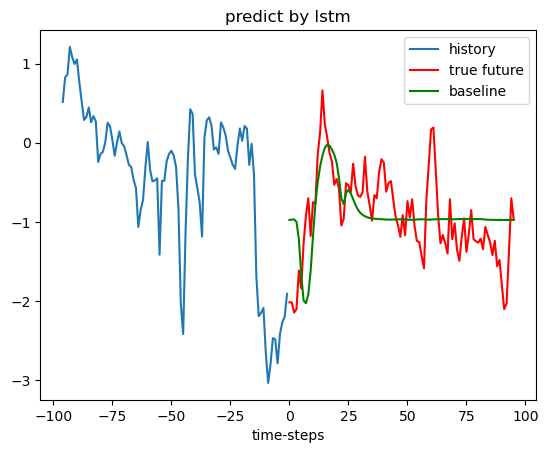

Epoch: 0; Batch: 1100; Loss: 0.2950887978076935;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


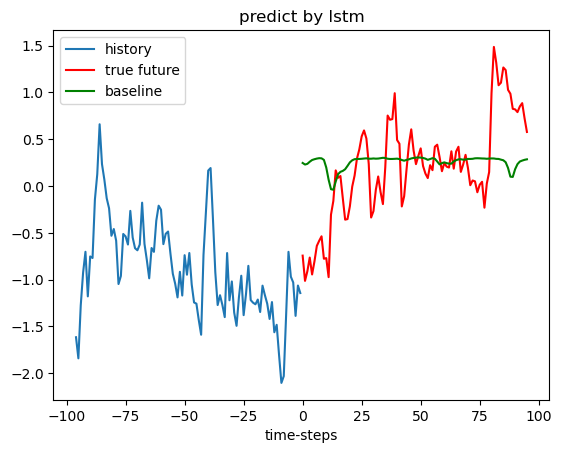

Epoch: 0; Batch: 1200; Loss: 0.7846383452415466;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


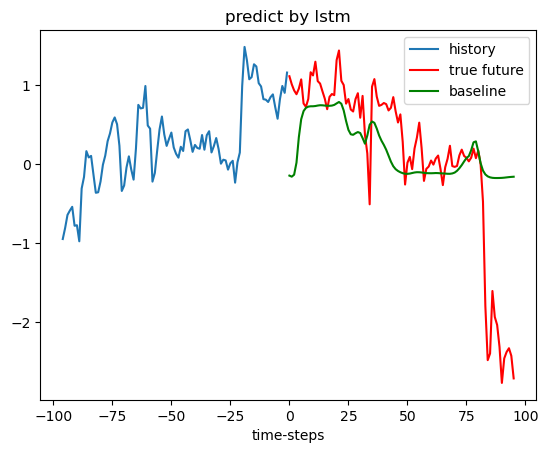

Epoch: 0; Batch: 1300; Loss: 0.3000107705593109;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


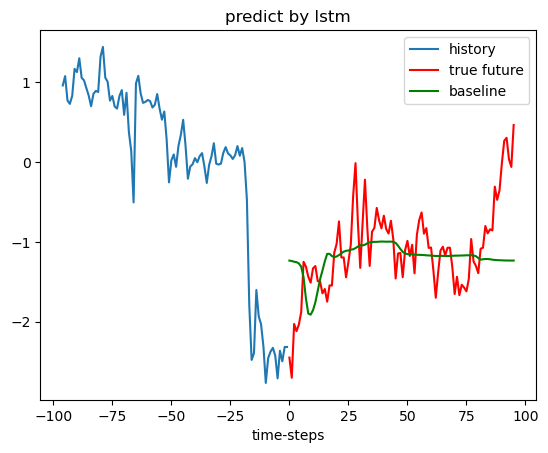

Epoch: 0; Batch: 1400; Loss: 0.1415463238954544;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


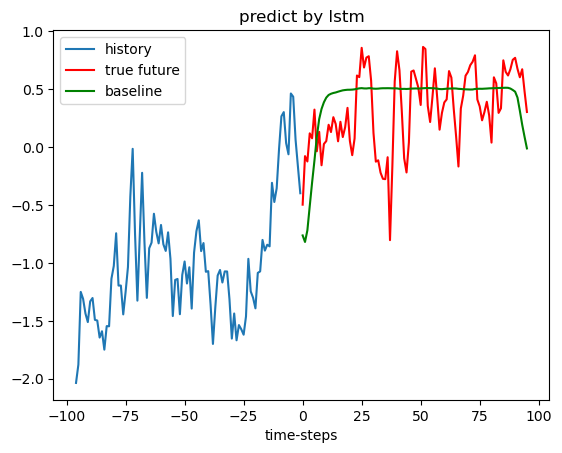

Epoch: 0; Batch: 1500; Loss: 0.5420995950698853;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


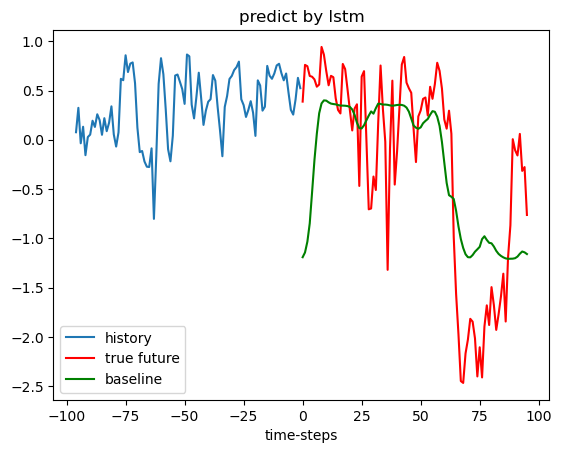

Epoch: 0; Batch: 1600; Loss: 0.11183544248342514;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


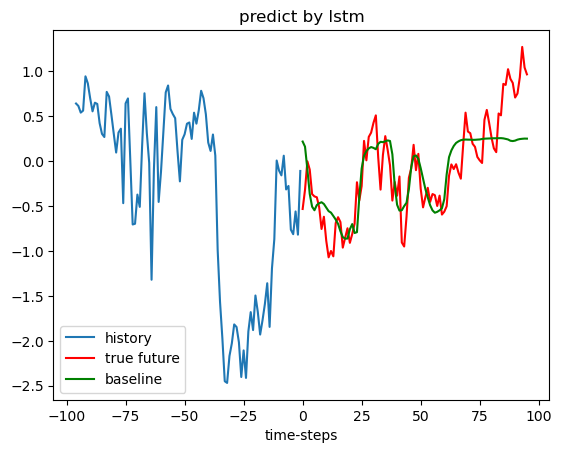

Epoch: 0; Batch: 1700; Loss: 0.12472053617238998;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


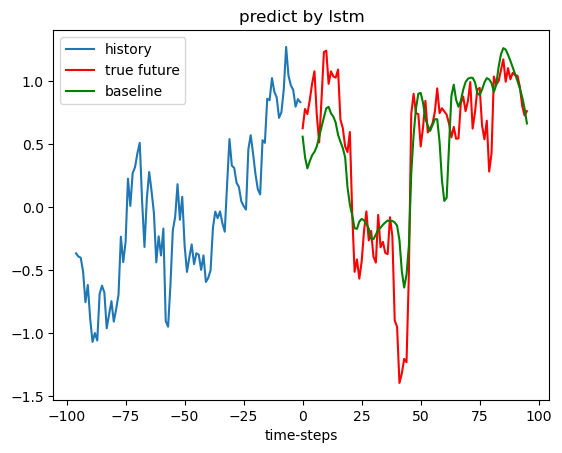

Epoch: 0; Batch: 1800; Loss: 0.3130834400653839;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


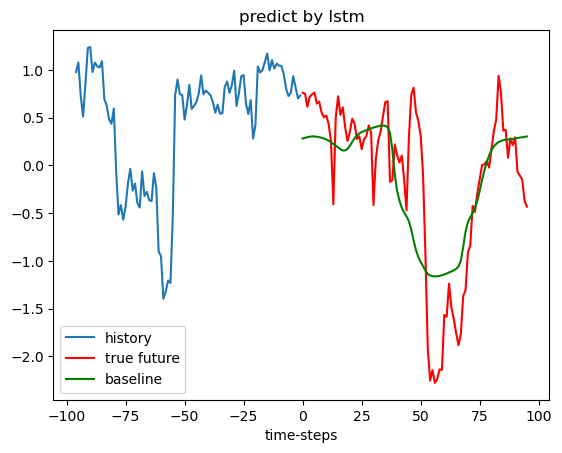

Epoch: 0; Batch: 1900; Loss: 0.15697501599788666;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


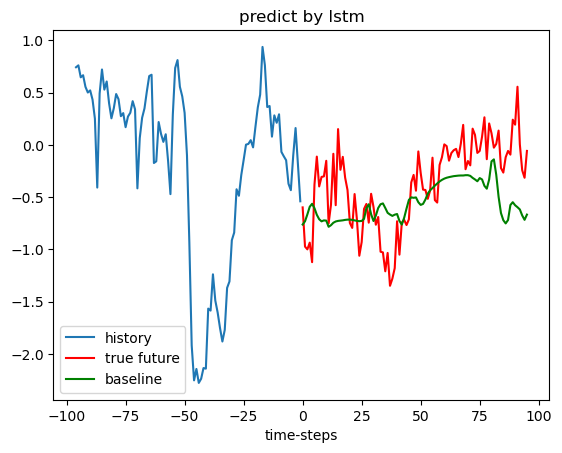

Epoch: 0; Batch: 2000; Loss: 0.21090714633464813;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


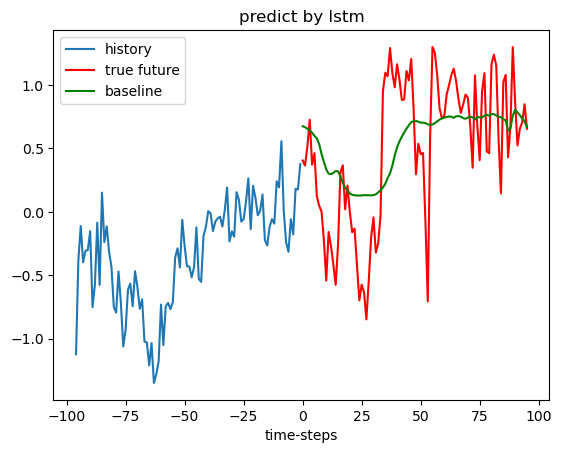

Epoch: 0; Batch: 2100; Loss: 0.2061135321855545;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


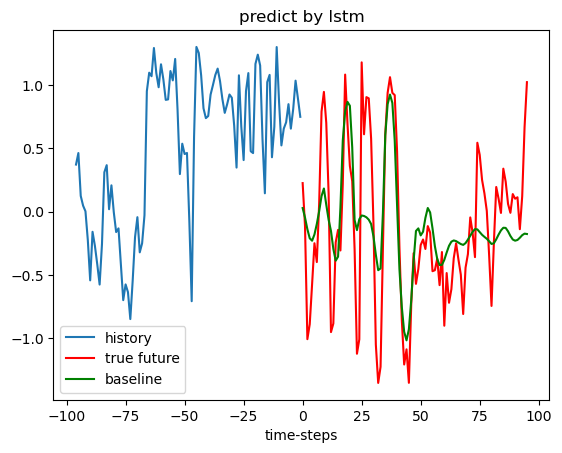

Epoch: 0; Batch: 2200; Loss: 0.24783019721508026;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


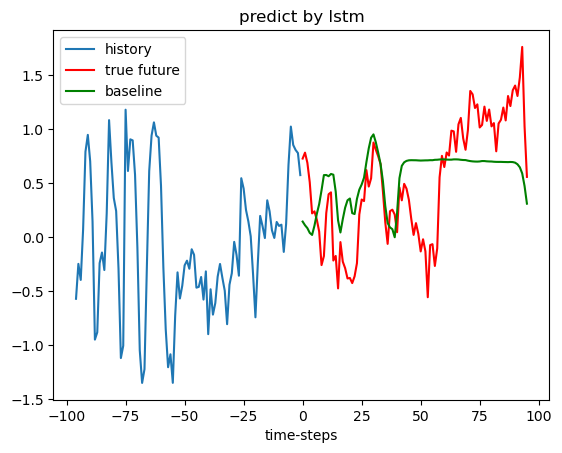

Epoch: 0; Batch: 2300; Loss: 0.344686895608902;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


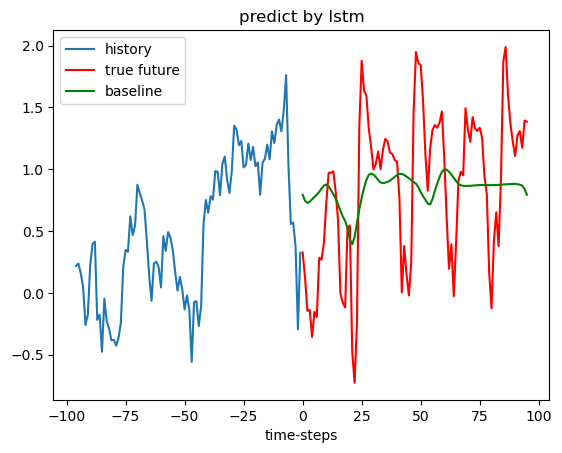

Epoch: 0; Batch: 2400; Loss: 0.38068869709968567;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


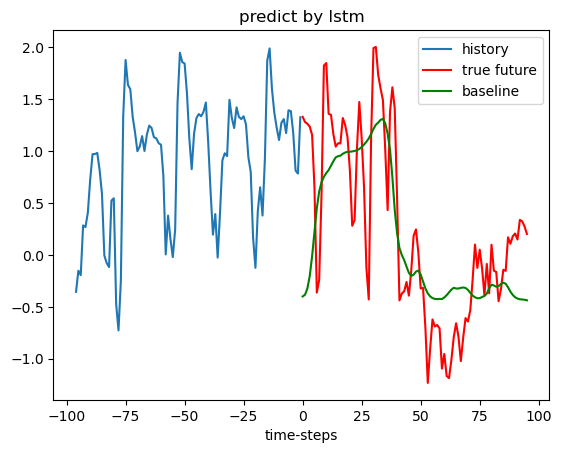

Epoch: 0; Batch: 2500; Loss: 0.21392785012722015;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


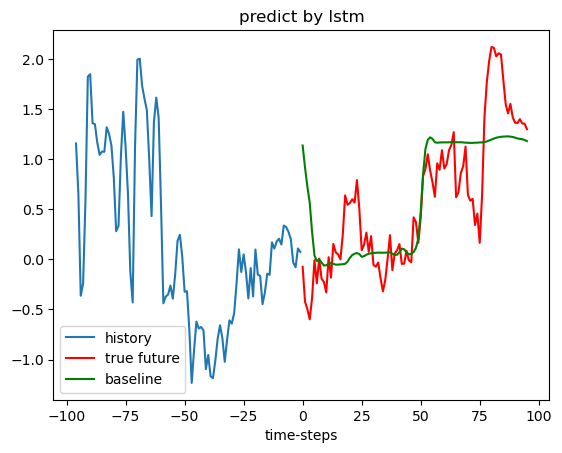

Epoch: 0; Batch: 2600; Loss: 0.38207772374153137;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


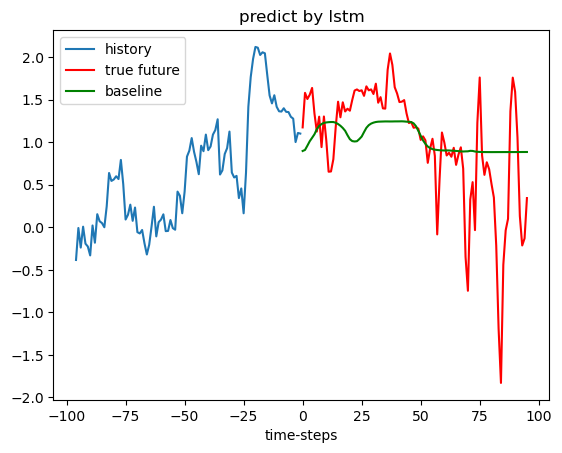

Epoch: 0; Batch: 2700; Loss: 0.2193918079137802;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


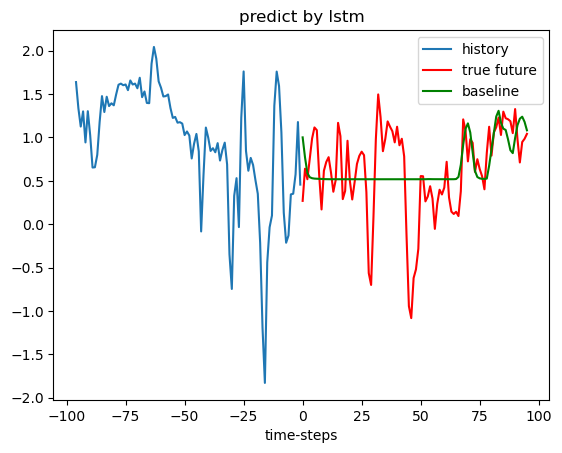

Epoch: 0; Batch: 2800; Loss: 0.23409628868103027;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


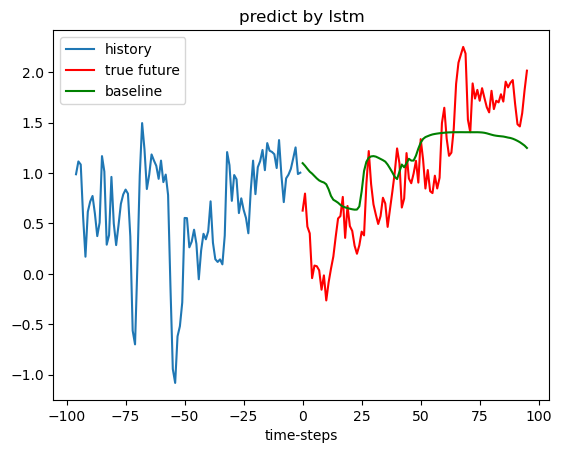

Epoch: 0; Batch: 2900; Loss: 0.3138852119445801;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


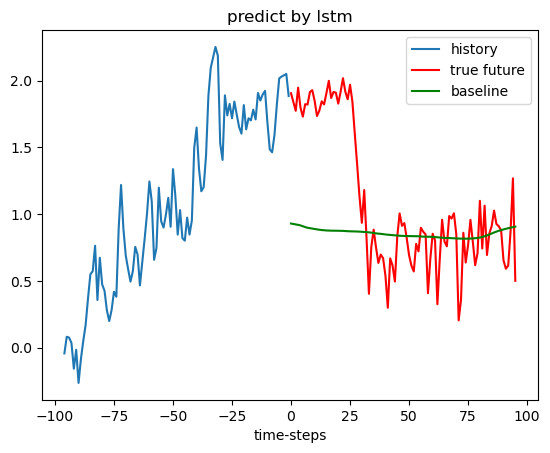

Epoch: 0; Batch: 3000; Loss: 0.44855403900146484;
torch.Size([96, 1]) range(-96, 0)
torch.Size([96]) range(0, 96)
(96, 1) range(0, 96)


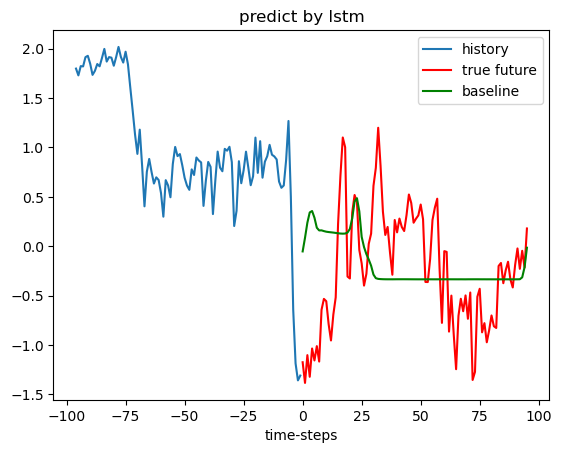

In [14]:
train(x_train_uni, y_train_uni, model, criterion, optimizer, n_epoch)